## Useful imports

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from src.preprocessing import data_diabetes, preprocessing

## Charging the csv in a dataframe

First step is to take a look at the data to know what we are dealing with.

We charge the csv in a panda dataframe and apply multiple methods to visualize the data.

A quick search to the source of the data (https://www.kaggle.com/datasets/alexteboul/diabetes-health-indicators-dataset?select=diabetes_binary_health_indicators_BRFSS2015.csv) gives us the information on the meaning of the data and precisions on the features.

In [11]:
df = pd.read_csv(data_diabetes)
df


,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253675,0.0,1.0,1.0,1.0,45.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,3.0,0.0,5.0,0.0,1.0,5.0,6.0,7.0
253676,1.0,1.0,1.0,1.0,18.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,4.0,0.0,0.0,1.0,0.0,11.0,2.0,4.0
253677,0.0,0.0,0.0,1.0,28.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,5.0,2.0
253678,0.0,1.0,0.0,1.0,23.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,3.0,0.0,0.0,0.0,1.0,7.0,5.0,1.0


253680 different patients and 22 features.

Most of the features are binary : 1.0 if true and 0.0 if false.

Couple exemples : 
- **"Diabetes_binary** : if the patient has diabetes.
- **"Fruits"** : if the patient eats at least one fruit a day.
- **"PhysHlth"** : if the patient practiced a physical activity in the last 30 days.
- **"Smoker"** : if the patient had more than 100 cigarettes (5 packs) in his life
- **"HighBP"** : high blood pressure

**"Sex"** is 0.0 for female and 1.0 for male

Some features have numerical values :
- **"BMI"** : Body Mass Index : weight(kg) / height(m)t^2 (18.5 to 24.9 is "normal", 25 to 29.9 is "overweight")
- **"MentHlth"** : Days of poor mental health on a 1 to 30 days scale
- **"Age"** : Using the 13-level age category -> 1 = 18-24 | 9 = 60-64 | 13 = 80 
- **"Education"** : level of studies -> 0 = never attended school or only kindergarden etc...
- **"Income"** : level of income on a 1 to 8 scale (in dollars) -> 1 = less than 10,000 | 5 = less than 35,000 | 8 = 75,000 or more

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Diabetes_binary       253680 non-null  float64
 1   HighBP                253680 non-null  float64
 2   HighChol              253680 non-null  float64
 3   CholCheck             253680 non-null  float64
 4   BMI                   253680 non-null  float64
 5   Smoker                253680 non-null  float64
 6   Stroke                253680 non-null  float64
 7   HeartDiseaseorAttack  253680 non-null  float64
 8   PhysActivity          253680 non-null  float64
 9   Fruits                253680 non-null  float64
 10  Veggies               253680 non-null  float64
 11  HvyAlcoholConsump     253680 non-null  float64
 12  AnyHealthcare         253680 non-null  float64
 13  NoDocbcCost           253680 non-null  float64
 14  GenHlth               253680 non-null  float64
 15  

In [13]:
df.describe()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
count,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,...,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000
mean,0.139333,0.429001,0.424121,0.962670,28.382364,0.443169,0.040571,0.094186,0.756544,0.634256,...,0.951053,0.084177,2.511392,3.184772,4.242081,0.168224,0.440342,8.032119,5.050434,6.053875
std,0.346294,0.494934,0.494210,0.189571,6.608694,0.496761,0.197294,0.292087,0.429169,0.481639,...,0.215759,0.277654,1.068477,7.412847,8.717951,0.374066,0.496429,3.054220,0.985774,2.071148
min,0.000000,0.000000,0.000000,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,1.000000,24.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,6.000000,4.000000,5.000000
50%,0.000000,0.000000,0.000000,1.000000,27.000000,0.000000,0.000000,0.000000,1.000000,1.000000,...,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,8.000000,5.000000,7.000000
75%,0.000000,1.000000,1.000000,1.000000,31.000000,1.000000,0.000000,0.000000,1.000000,1.000000,...,1.000000,0.000000,3.000000,2.000000,3.000000,0.000000,1.000000,10.000000,6.000000,8.000000
max,1.000000,1.000000,1.000000,1.000000,98.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,5.000000,30.000000,30.000000,1.000000,1.000000,13.000000,6.000000,8.000000


For binary features, the mean acts as a computation of the percentage of the patients which validate it.

A quick look at the means of the different binary features shows for exemple that most of the patients had a cholesterol check in the last 5 years (0.96), that around half of them smoke (0.44) and that around 14% of them has diabetes (0.139)

We can print exactly the number of patient having diabetes :

In [14]:
df["Diabetes_binary"].value_counts()

Diabetes_binary
0.0    218334
1.0     35346
Name: count, dtype: int64

It is interesting to see the correlation between features. Here we choose features that seems more relevant than others to determine if a patient has diabetes to keep the correlation matrix readable.

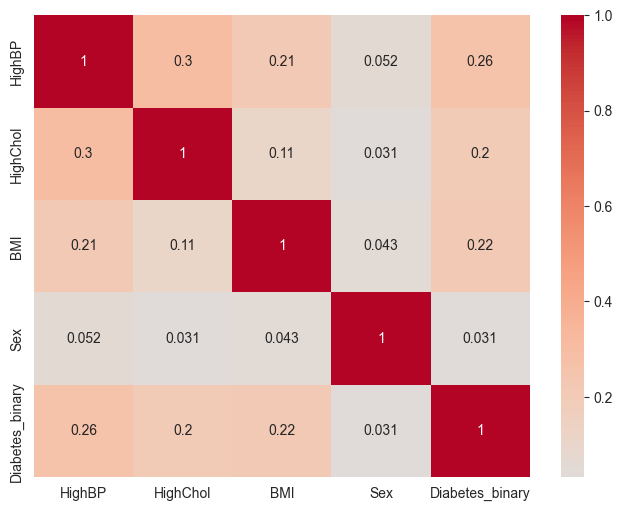

In [15]:
relevant_features = ["HighBP", "HighChol", "BMI", "Sex", "Diabetes_binary"]
corr = df[relevant_features].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
plt.show()

We can see the distribution of each feature on diabetics and no diabetics

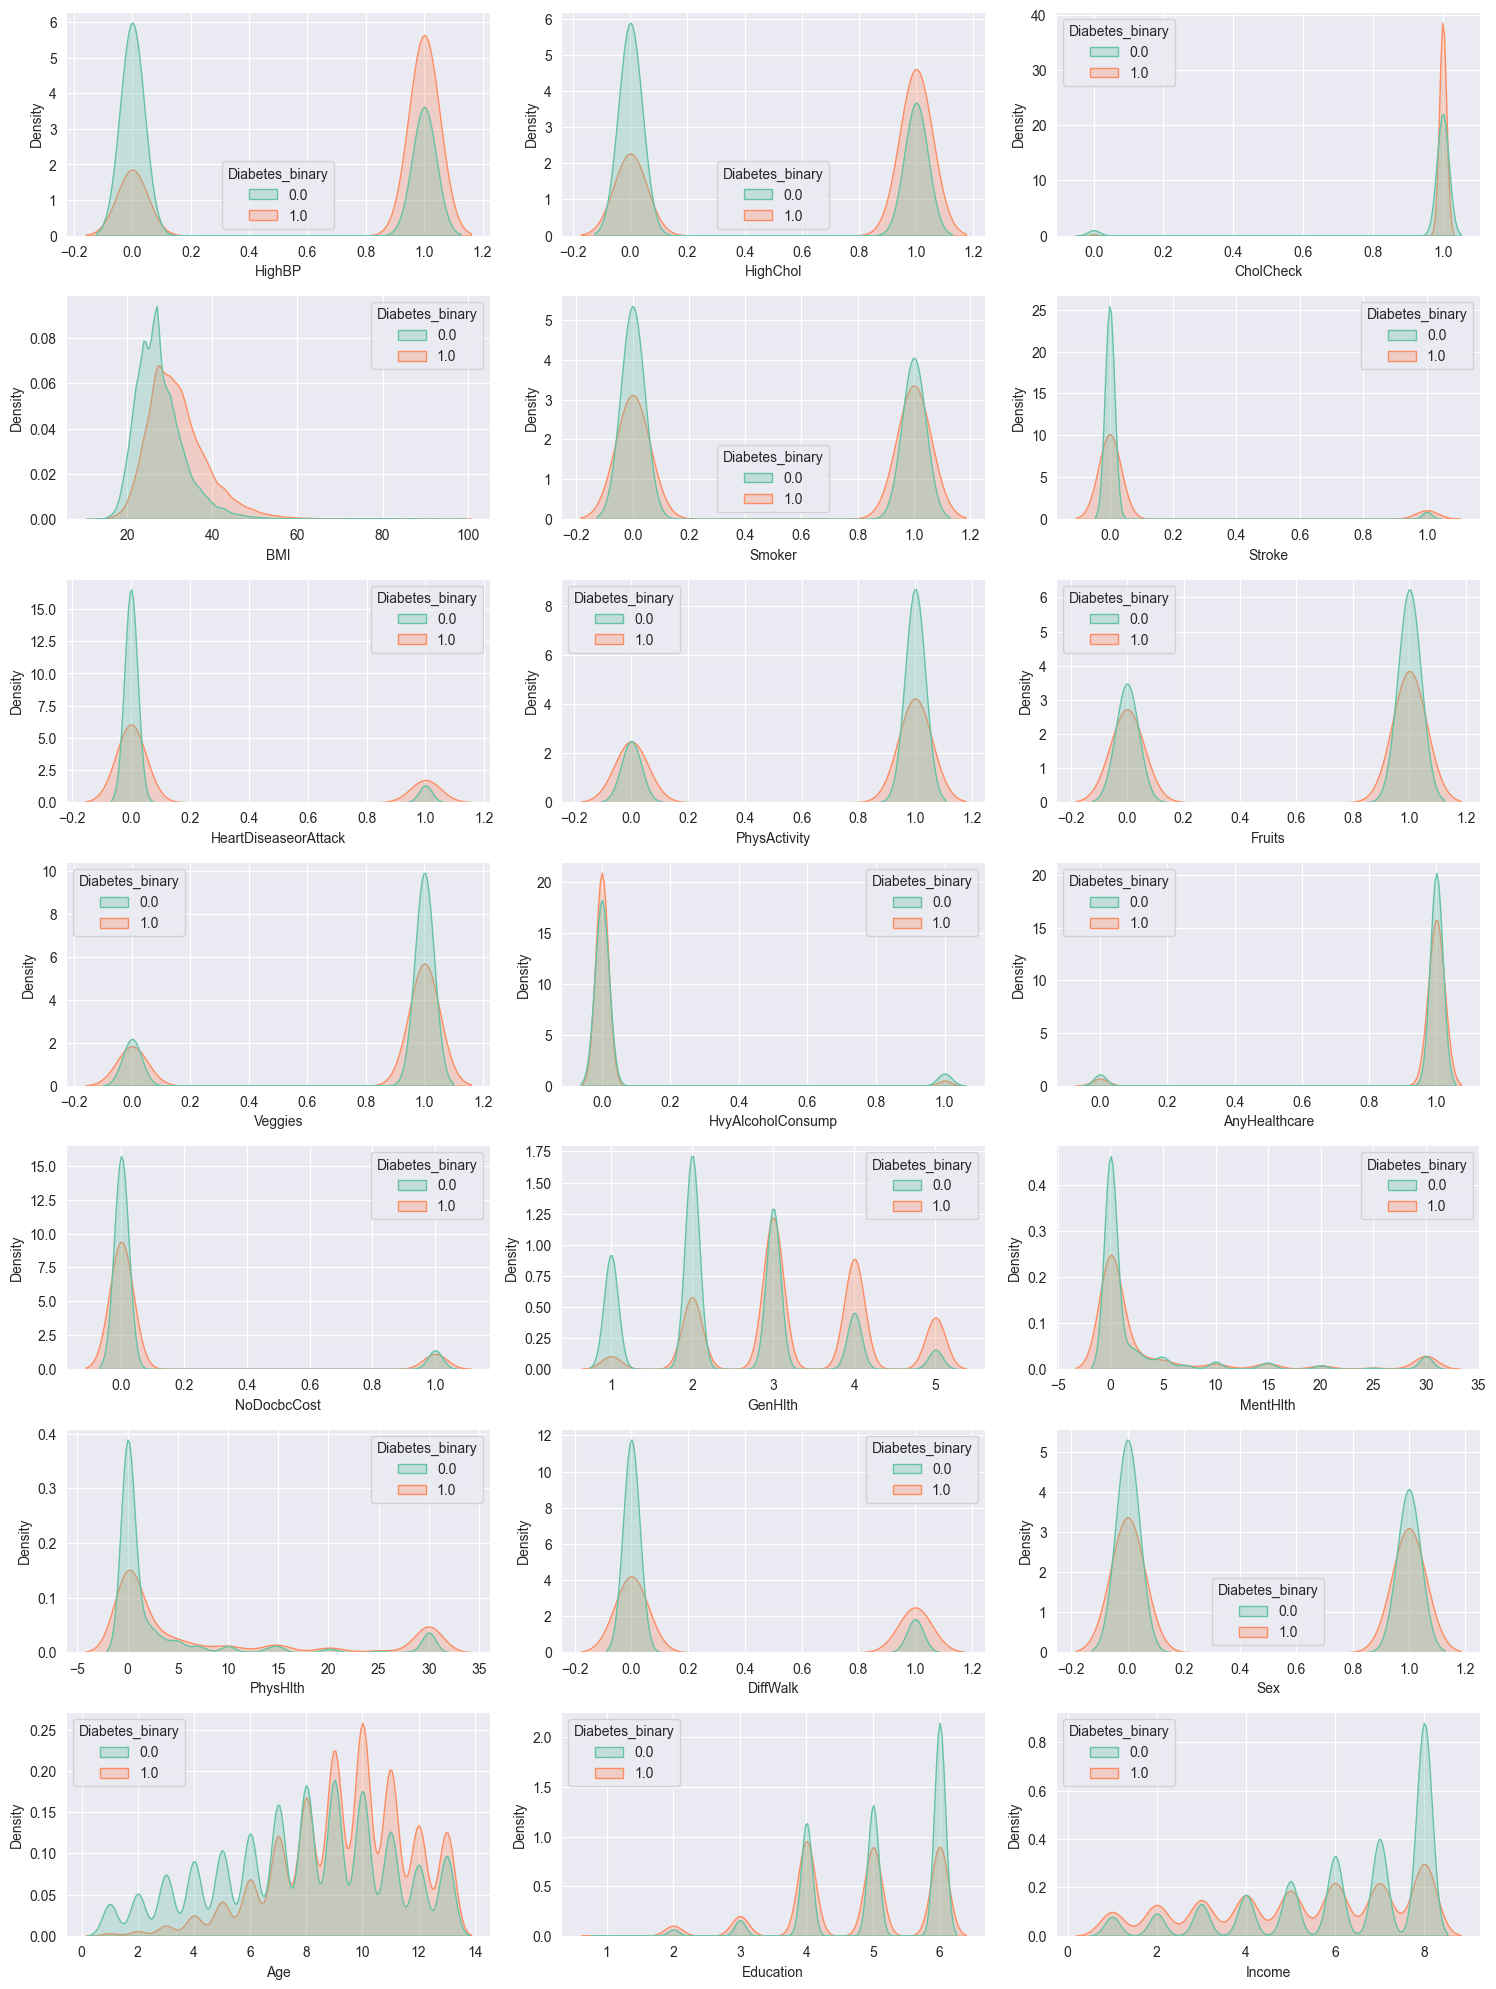

In [16]:
fig, axes = plt.subplots(7, 3, figsize=(15, 20))
axes = axes.flatten()
for idx, feature in enumerate(df.columns[1:]):
    sns.kdeplot(
        data=df, x=feature, hue="Diabetes_binary", ax=axes[idx], fill=True, palette="Set2", alpha=0.3, common_norm=False
    )
    axes[idx].grid(True)
plt.tight_layout()
plt.show()

## Analysis

# K nearest neighbour


The first algorithm we decide to use is the KNN algorithm as it is easy and quick to implement. 

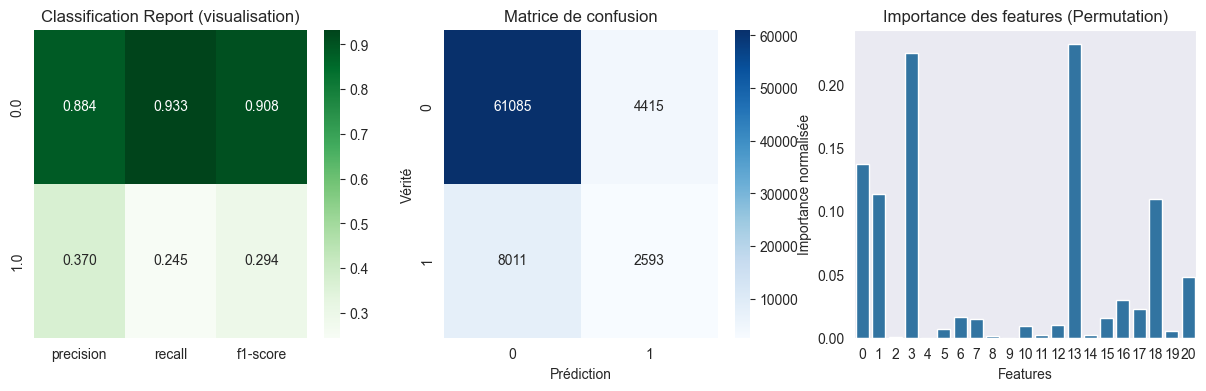

In [18]:
from src.knn import KNNModel

samples = preprocessing(data=data_diabetes, test_size=0.3, validation_size=0.1)
model = KNNModel()
model.train(x=samples.X_train, y=samples.y_train)
model.benchmark(x=samples.X_test, y=samples.y_test)

We have the best results for K = 3.     
At first sight, the results seem very good : for the non-diabetic people the precision is 88% and recall is 93%. 
However we see there is a problem when considering the diabic people : the precision is 37% and recall is 24%.  

We decide to select only the features with an importance superior to 0.05 to see if it can improve the model and make it more interpretable.

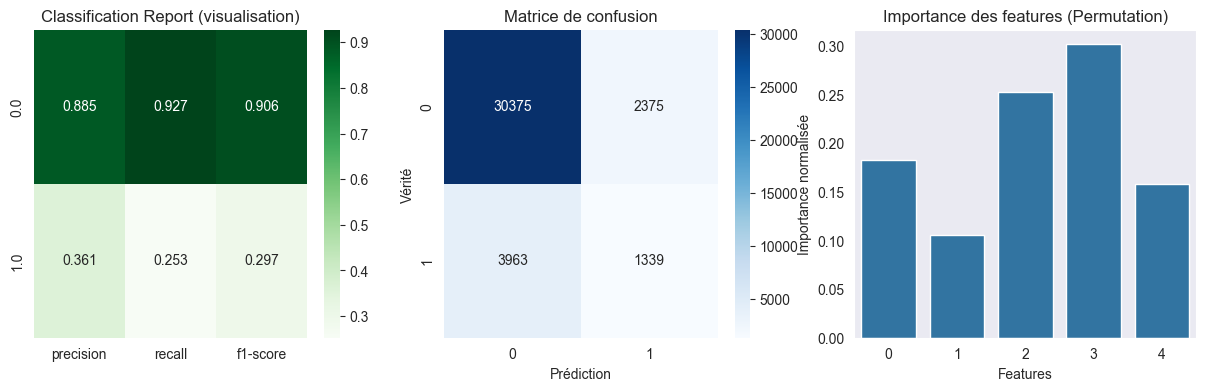

In [19]:
samples = preprocessing(data=data_diabetes, test_size=0.15, validation_size=0.15)

cols = [0, 1, 3, 13, 18]
samples.X_train = samples.X_train[:, cols]
samples.X_test = samples.X_test[:, cols]
samples.X_validation = samples.X_validation[:, cols]

model = KNNModel()
model.train(x=samples.X_train, y=samples.y_train)
model.benchmark(x=samples.X_test, y=samples.y_test)

There isn't any improvement in the model but the training and prediction is much faster. 
We can conclude that the diabete dataset is more complex than the spam dataset : we need a more complex algorithm than KNN.   

# Neural network : MLP

In [20]:
from src.nn_interface import MLPModel

samples = preprocessing(data=data_diabetes, test_size=0.15, validation_size=0.15)
model = MLPModel(input_size=21, epochs=15)
model.train(samples)

epoch: 1 	training Loss: 0.984575 
Validation loss improved → new best = 0.929653
epoch: 2 	training Loss: 0.957650 
Validation loss improved → new best = 0.926773
epoch: 3 	training Loss: 0.951225 
No improvement in validation loss (current: 0.929351, best: 0.926773) → reverting weights
epoch: 4 	training Loss: 0.946614 
Validation loss improved → new best = 0.925786
epoch: 5 	training Loss: 0.944168 
Validation loss improved → new best = 0.922442
epoch: 6 	training Loss: 0.944423 
No improvement in validation loss (current: 0.922983, best: 0.922442) → reverting weights
epoch: 7 	training Loss: 0.941513 
No improvement in validation loss (current: 0.922743, best: 0.922442) → reverting weights
epoch: 8 	training Loss: 0.941171 
Validation loss improved → new best = 0.920588
epoch: 9 	training Loss: 0.939108 
No improvement in validation loss (current: 0.922148, best: 0.920588) → reverting weights
epoch: 10 	training Loss: 0.937871 
No improvement in validation loss (current: 0.920751, 

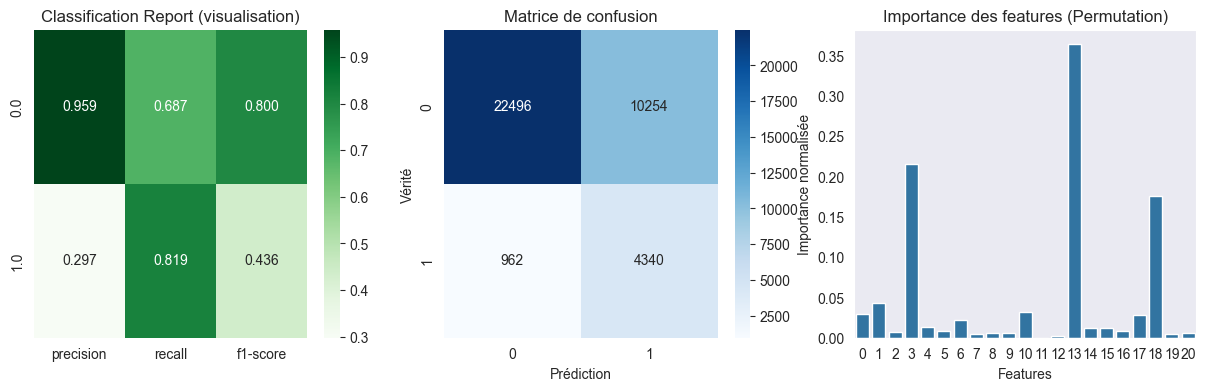

In [21]:
model.benchmark(samples.X_test, samples.y_test)

We decide to use a MLP with 3 hidden layers to tackle this complex dataset as neural networks are very powerful.  
We observe far better results than for KNN : precision for diabetic people is around 29% but recall is approx 83%. That means that the algorithm detects 83% of the diabetic cases which is a pretty good result. Indeed, eventhough the algorithm classifies non-diabetic people as diabetic people this doesn't have dramatic consequences. On the contrary, if diabetic people are classified as non-diabetic, it can have problematic consequences.
That's why we prefer to have a high recall and a low precision for class 1 than a low recall and a high precision. 
Moreover the precision for diabetic people is very high (96%) and recall remains high (67%).  
We can note that some features seem to have played a bigger role than others when predicting : GenHlth (36% of feature importance), BMI (20%) and age (18%).

However if we compare with the spam dataset, the training is much longer because of the amount of data but the loss doesn't decrease that much : the MLP struggles to reach excellent performances, only 15 epochs are sufficient


We decide to select only the 5 features that have an importance above 0.05 to train our model again and see if we have better results. 

In [22]:
samples = preprocessing(data=data_diabetes, test_size=0.15, validation_size=0.15)

cols = [0, 1, 3, 13, 18]
samples.X_train = samples.X_train[:, cols]
samples.X_test = samples.X_test[:, cols]
samples.X_validation = samples.X_validation[:, cols]


model = MLPModel(input_size=5, epochs=15)
model.train(samples)



epoch: 1 	training Loss: 0.990128 
Validation loss improved → new best = 0.940907
epoch: 2 	training Loss: 0.968340 
No improvement in validation loss (current: 0.943168, best: 0.940907) → reverting weights
epoch: 3 	training Loss: 0.966798 
No improvement in validation loss (current: 0.945887, best: 0.940907) → reverting weights
epoch: 4 	training Loss: 0.963414 
No improvement in validation loss (current: 0.943294, best: 0.940907) → reverting weights
epoch: 5 	training Loss: 0.964453 
No improvement in validation loss (current: 0.941489, best: 0.940907) → reverting weights
epoch: 6 	training Loss: 0.962944 
Validation loss improved → new best = 0.940871
epoch: 7 	training Loss: 0.961000 
No improvement in validation loss (current: 0.941810, best: 0.940871) → reverting weights
epoch: 8 	training Loss: 0.960536 
No improvement in validation loss (current: 0.944209, best: 0.940871) → reverting weights
epoch: 9 	training Loss: 0.961434 
Validation loss improved → new best = 0.937796
epoc

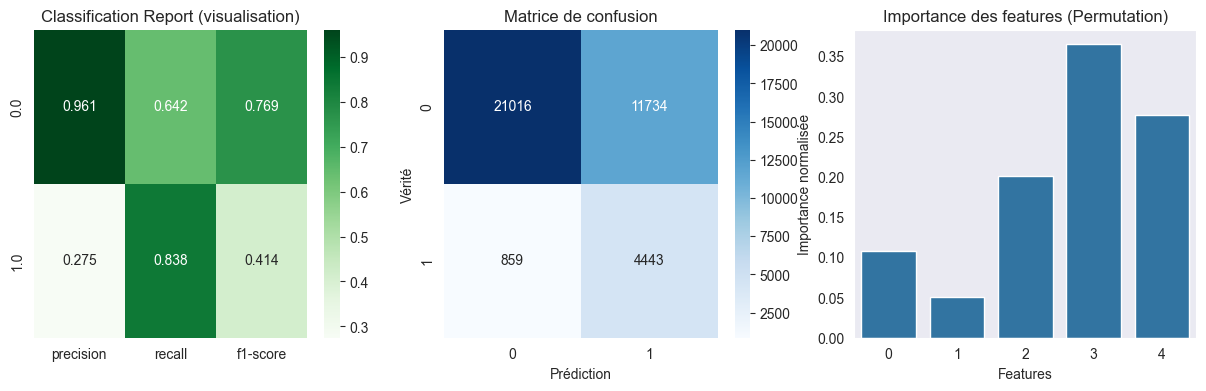

In [23]:
model.benchmark(samples.X_test, samples.y_test)

We don't see any improvement in our model : we have the same results as before.

# Random Forest

In [24]:
from src.RForest import RForest

samples = preprocessing(data=data_diabetes, test_size=0.3, validation_size=0.1)
model = RForest()
model.train(x=samples.X_train, y=samples.y_train)

Best hyperparameters found with Grid Search: {'max_depth': None, 'min_samples_leaf': 2, 'n_estimators': 200}


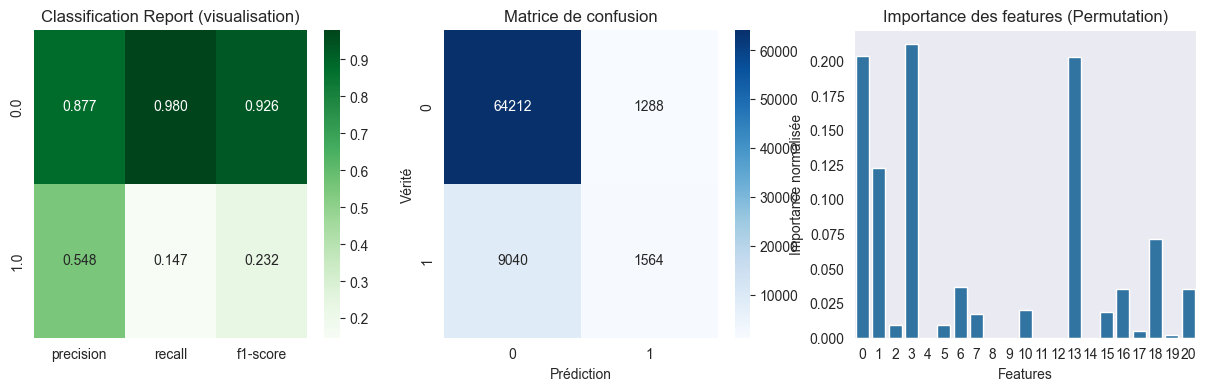

In [25]:
model.benchmark(x=samples.X_test, y=samples.y_test)

The Random Forest isn't effective at all to tackle this problem even when we optimize the hyperparameters by using a Grid Search. Recall for class 1 is around 15% which is even worse than for the KNN model...  
However an interesting thing that we can notice is that the MLP and the Random Forest use some of the same features to predict the results  : BMI, GenHlth and age. The other important features are HighBP and HighChol. 

Once again we decide to select only the features with an importance superior to 0.05. This will able the model to be more efficient and maybe have better results as the GridSearch on Random Forest takes a lot of time. 

In [ ]:
samples = preprocessing(data=data_diabetes, test_size=0.15, validation_size=0.15)

cols = [0, 1, 3, 13, 18]
samples.X_train = samples.X_train[:, cols]
samples.X_test = samples.X_test[:, cols]
samples.X_validation = samples.X_validation[:, cols]


model = RForest()
model.train(x=samples.X_train, y=samples.y_train)
model.benchmark(x=samples.X_test, y=samples.y_test)

The model was way more faster to train with only these 5 features. However the results are not better than before : the recall is even worse than the previous model. 

# Linear SVC

In [22]:
from src.kernel_methods import LinearSVC_

samples = preprocessing(data=data_diabetes, test_size=0.3, validation_size=0.1)
model = LinearSVC_()
model.train(x=samples.X_train, y=samples.y_train)

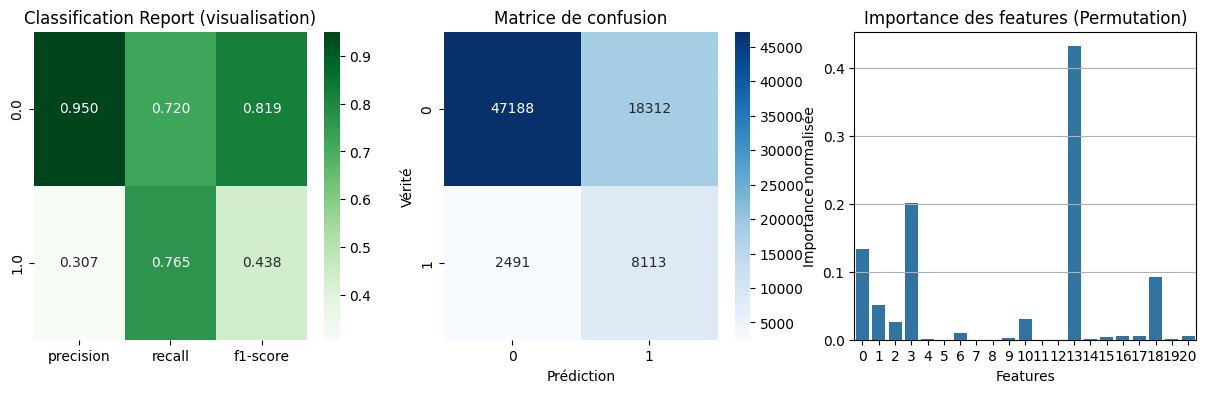

In [23]:
model.benchmark(x=samples.X_test, y=samples.y_test)

To optimise the hyperparameters used by the LinearSVC model we use a Grid Search. 
The LinearSVC model we use here is almost as good as the MLP model we used above : we have a recall of 76.5% for class 1 while still having a precision of 85% and a recall of 72% for class 0.  
We notice that this model uses less features than the others. However is has also important features in common (BMI, GenHlth, age) with the MLP and the KNN and it uses HighBP like RandomForest.  

We decide once again to select only the most important features to train our model once again. 

Best hyperparameters found with Grid Search: {'C': 0.01}


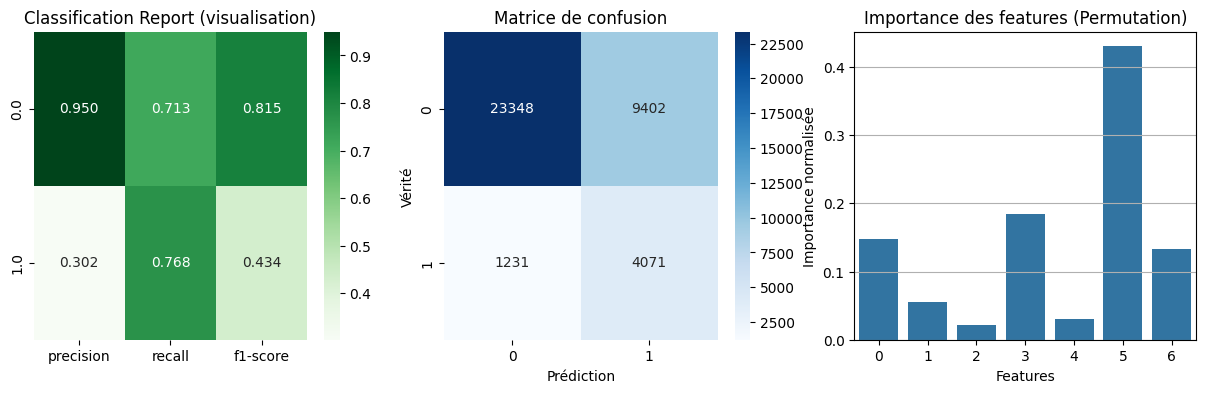

In [ ]:
samples = preprocessing(data=data_diabetes, test_size=0.15, validation_size=0.15)

cols = [0, 1, 2, 3, 10, 13, 18]
samples.X_train = samples.X_train[:, cols]
samples.X_test = samples.X_test[:, cols]
samples.X_validation = samples.X_validation[:, cols]


model = LinearSVC_()
model.train(x=samples.X_train, y=samples.y_train)
model.benchmark(x=samples.X_test, y=samples.y_test)

The feature selection doesn't improve the results either.

## Conclusion : 

The model for diabetes being more complex than the model for spams, the KNN and Random Forest algorithms are not useful anymore.  
The neural networks and LinearSVC, eventhough they are not perfect, achieve very good recall scores for class 1 (80% and 76%) while maintaining high precision and recall scores for class 0.  
Thus, for this diabete problem, the neural network is the best model.   
Note that we can increase the recall for class 1 by playing on the decision threshold (person is classified as diabetic when probability is above 0.3 for example). 
Moreover we decided to do some selection features to keep only the most important features : this doesn't improve the models but it makes the models clearer and more easily interpretable.